In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from collections import Counter

## Part 1

In [4]:
reg_path = "Assignment/data/RESISTORS/"
img_path = reg_path+'RESISTORS-1.png'
img = Image.open(img_path)

In [5]:
# Define a function to separate each resistor
def separate_resistors(image):
    width, height = image.size
    pixels = image.load()
    gap_threshold = height * 0.9
    white_threshold = 250  
    gap_indices = []
    for x in range(width):
        white_count = sum(1 for y in range(height) if pixels[x, y] >= (white_threshold, white_threshold, white_threshold))
        if white_count > gap_threshold:
            gap_indices.append(x)
    resistor_bounds = []
    start_x = 0
    for gap_x in gap_indices:
        end_x = gap_x
        if end_x - start_x > 1:  
            resistor_bounds.append((start_x, 0, end_x, height))
        start_x = gap_x + 1
    if start_x < width:
        resistor_bounds.append((start_x, 0, width, height))
    resistor_images = [image.crop(bounds) for bounds in resistor_bounds]
    return resistor_images

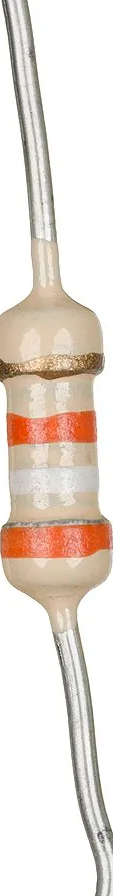

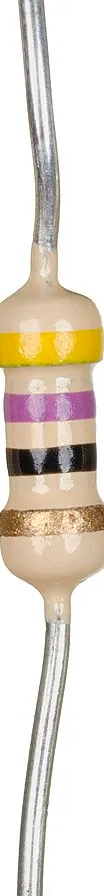

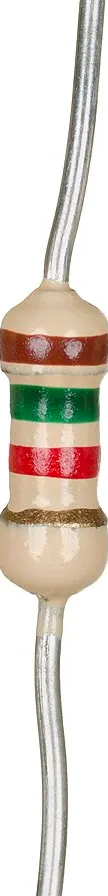

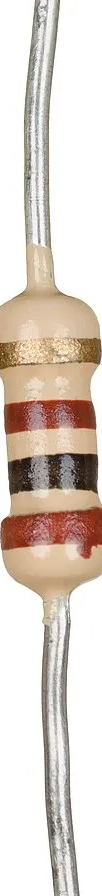

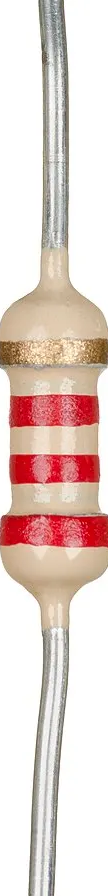

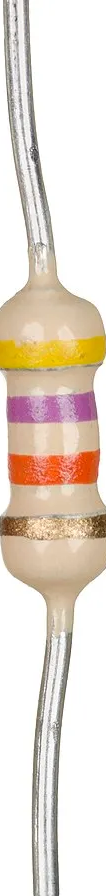

In [6]:
resistor_imgs = separate_resistors(img)
# Save separated resistor photos
separated_img_paths = []
for i, resistor_img in enumerate(resistor_imgs):
    path = f'resistor_{i}.png'
    resistor_img.save(path)
    separated_img_paths.append(path)
separated_img_paths
from IPython.display import Image, display


# 循环遍历每个路径并显示图片
for img_path in separated_img_paths:
    display(Image(filename=img_path))


In [5]:
def remove_resistor_backgroud(image_path, output_path):
    image = Image.open(image_path)
    # Convert to RGBA
    image = image.convert('RGBA')
    # Convert the image to numpy array
    data = np.array(image)
    white_threshold = 240
    # Create a mask where white is set to True and the rest to False
    white_areas = (data[:,:,0] > white_threshold) \
                  & (data[:,:,1] > white_threshold) \
                  & (data[:,:,2] > white_threshold)
    # Set the alpha channel to 0 for all white areas (making them transparent)
    data[white_areas, -1] = 0
    # Convert the numpy array back to an image
    image_no_white = Image.fromarray(data)
    # Save the image without white background
    image_no_white.save(output_path)

In [6]:
for i in range(len(resistor_imgs)):
    image_path = f'resistor_{i}.png'
    output_path = f'RESISTORS_{i}_no_white.png'
    remove_resistor_backgroud(image_path, output_path)

In [7]:
def remove_wire(input_path, output_path):
    fill_color= (255, 255, 255)
    # 加载原始图像
    image = Image.open(input_path)
    width, height = image.size

    # 初始化一个列表来存储要保留的行
    rows_to_keep = []

    # 处理图像水平方向
    for y in range(height):
        row = [image.getpixel((x, y)) for x in range(width)]  # 获取整行像素
        opaque_count = sum(1 for pixel in row if pixel[3] >= (255 / 2))

        # 如果不透明像素超过行宽的50%，则保留这行
        if opaque_count >= (width / 2):
            rows_to_keep.append(row)

    # 创建新图像
    new_height = len(rows_to_keep)
    new_image = Image.new('RGB', (width, new_height), fill_color)  # 使用指定的填充颜色

    # 将保留的行复制到新图像
    for y, row in enumerate(rows_to_keep):
        for x, pixel in enumerate(row):
            # 只复制不透明的像素
            if pixel[3] >= (255 / 2):
                new_image.putpixel((x, y), (pixel[0], pixel[1], pixel[2]))

    # 保存为JPEG
    new_image.save(output_path, 'JPEG')

In [8]:
for i in range(len(resistor_imgs)):
    image_path = f'RESISTORS_{i}_no_white.png'
    output_path = f'RESISTORS_{i}_transparent_horizontal.jpg'
    remove_wire(image_path, output_path)


In [9]:
# Self_defined color boundaries
color_boundaries = {
    'black': ([0, 0, 0], [180, 255, 70]),
    'brown': ([1, 100, 100], [12, 255, 170]),
    'red': ([80, 150, 100], [200, 255, 255]),
    'orange': ([5, 100, 160], [15, 255, 255]),
    'yellow': ([17, 100, 180], [25, 255, 255]),
    'green': ([35, 100, 0], [85, 255, 255]),
    'blue': ([85, 100, 100], [135, 255, 255]),
    'violet': ([100, 80, 80], [160, 255, 255]),
    # 'grey': ([0, 0, 40], [180, 50, 80]), 
    'white': ([0, 0, 200], [180, 20, 255]),
    'gold': ([12, 100, 100], [20, 200, 240]), #没问题
    # 'gold': ([11, 60, 100], [30, 255, 180]),
    # 'silver': ([0, 0, 50], [180, 15, 255]) 
}

In [10]:
def get_hsv_list(image_path, num_lines=5):
    image = cv2.imread(image_path)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    def extract_hsv_values(hsv_image, line_position):
        return hsv_image[:, line_position, :]

    width = hsv.shape[1]
    line_positions = [width * i // num_lines for i in range(num_lines)]
    hsv_lists = []

    for position in line_positions:
        hsv_values = extract_hsv_values(hsv, position)
        hsv_list = [tuple(hsv_values[i]) for i in range(hsv_values.shape[0])]
        hsv_lists.append(hsv_list)
    return hsv_lists
def identify_color(hsv_value, color_boundaries):
    for color, (lower, upper) in color_boundaries.items():
        if all(lower[i] <= hsv_value[i] <= upper[i] for i in range(3)):
            return color
    return 'undefined'
def hsv_lists_to_colour(hsv_list1, hsv_list2, hsv_list3):
    color_names = []
    for hsv1, hsv2, hsv3 in zip(hsv_list1, hsv_list2, hsv_list3):
        color1 = identify_color(hsv1, color_boundaries)
        color2 = identify_color(hsv2, color_boundaries)
        color3 = identify_color(hsv3, color_boundaries)

        # 检查至少有两个列表中的颜色是否相同
        if color1 == color2 or color1 == color3 or color2 == color3:
            if color1 != 'undefined':
                color_names.append(color1)
            elif color2 != 'undefined':
                color_names.append(color2)
            elif color3 != 'undefined':
                color_names.append(color3)
    return color_names

def colour_filters(colors):
    def convert_list_to_format(lst):
        """
        Convert a list of elements into a formatted string that groups consecutive identical elements
        and indicates the count of each group.
    
        Example:
        Input: [1,1,1,2,2,2,3,3,2,3,3,2,3,1]
        Output:
        '1: 3个元素\n2: 3个元素\n3: 2个元素\n2: 1个元素\n3: 2个元素\n2: 1个元素\n3: 1个元素\n1: 1个元素'
        """
        formatted_output = []
        count = 1
    
        for i in range(1, len(lst)):
            if lst[i] == lst[i-1]:
                count += 1
            else:
                formatted_output.append(f"{lst[i-1]}: {count}个元素")
                count = 1
    
        # Add the last element
        formatted_output.append(f"{lst[-1]}: {count}个元素")
    
        return '\n'.join(formatted_output)

    print(convert_list_to_format(colors))
    color_counts = Counter(colors)
    top_colors = [color for color, count in color_counts.most_common(4) if count > 2]
    print(top_colors)
    filtered_colors = []
    for color in colors:
        if color in top_colors:
            filtered_colors.append(color)
    return filtered_colors
def extract_unique_colors(color_list):
    def remove_elements_with_few_occurrences(lst):
        if not lst:  # 如果列表为空，直接返回空列表
            return []
    
        new_list = []
        count = 1  # 初始化计数器
        prev_element = lst[0]
    
        for element in lst[1:] + [None]:  # 遍历列表，并在末尾添加一个不同的元素以确保最后一组元素被处理
            if element == prev_element:
                count += 1  # 相同元素计数加1
            else:
                if count > 2:  # 如果前一个元素连续出现次数达到2次以上
                    new_list.extend([prev_element] * count)  # 将这个元素连同它的重复次数一起添加到新列表中
                count = 1  # 重置计数器
            prev_element = element
    
        return new_list
    color_list = remove_elements_with_few_occurrences(color_list)
    uniq = []
    times_l = []
    curr = color_list[0]
    times = 0
    for i in color_list:
        if i == curr:
            times+=1
        else:
            uniq.append(curr)
            times_l.append(times)
            curr = i
            times = 1
    uniq.append(curr)
    def find_max_position(lst):
        max_value = max(lst)
        max_position = lst.index(max_value)
        return max_position
    def closest_number(target):
        num1 = 1/3
        num2 = 1
        num3 = 3
        
        # 计算每个数字与目标数字的差的绝对值
        diff1 = abs(target - num1)
        diff2 = abs(target - num2)
        diff3 = abs(target - num3)
    
        # 找出最小差异
        min_diff = min(diff1, diff2, diff3)
    
        # 确定最接近的数字
        if min_diff == diff1:
            return 1
        elif min_diff == diff2:
            return 2
        else:
            return 3
    if len(uniq) == 4: 
        return uniq
    elif len(uniq)==3:
        pos = find_max_position(times_l)
        color = uniq[pos]
        uniq.insert(pos,color)
        return uniq
    elif len(uniq) == 2:   
        ratio = float(times_l[0])/float(times_l[1])
        close_number = closest_number(ratio)
        if close_number == 1:
            uniq.insert(-1,uniq[-1])
            uniq.insert(-1,uniq[-1])
        elif close_number == 2:
            uniq.insert(0, uniq[0])
            uniq.insert(-1, uniq[-1])
        elif close_number == 3:
            uniq.insert(0, uniq[0])
            uniq.insert(0, uniq[0])
        return uniq
    elif len(uniq) == 1:
        uniq.insert(0,uniq[0])
        uniq.insert(0,uniq[0])
        uniq.insert(0,uniq[0])
        return uniq
    else:
        return uniq[:4]

In [11]:
for i in range(len(resistor_imgs)):
    image_path = f'RESISTORS_{i}_transparent_horizontal.jpg'
    hsv_list = get_hsv_list(image_path)
    color_names = hsv_lists_to_colour(hsv_list[1],hsv_list[2],hsv_list[3])
    print(f'第{i}个')
    filtered_colors = colour_filters(color_names)
    print(extract_unique_colors(filtered_colors))

第0个
orange: 2个元素
gold: 10个元素
orange: 32个元素
white: 32个元素
orange: 34个元素
white: 4个元素
['orange', 'white', 'gold']
['gold', 'orange', 'white', 'orange']
第1个
white: 1个元素
yellow: 36个元素
violet: 23个元素
black: 23个元素
gold: 9个元素
yellow: 1个元素
gold: 1个元素
yellow: 1个元素
gold: 4个元素
orange: 2个元素
gold: 2个元素
orange: 1个元素
gold: 1个元素
orange: 2个元素
gold: 1个元素
orange: 1个元素
white: 5个元素
['yellow', 'violet', 'black', 'gold']
['yellow', 'violet', 'black', 'gold']
第2个
white: 5个元素
orange: 1个元素
brown: 28个元素
orange: 1个元素
brown: 1个元素
orange: 1个元素
green: 5个元素
black: 1个元素
green: 30个元素
orange: 1个元素
red: 25个元素
orange: 1个元素
brown: 1个元素
red: 2个元素
gold: 12个元素
white: 3个元素
['green', 'brown', 'red', 'gold']
['brown', 'green', 'red', 'gold']
第3个
gold: 3个元素
brown: 1个元素
orange: 1个元素
brown: 29个元素
orange: 1个元素
black: 22个元素
brown: 3个元素
orange: 1个元素
brown: 9个元素
orange: 1个元素
brown: 15个元素
orange: 4个元素
['brown', 'black', 'orange', 'gold']
['gold', 'brown', 'black', 'brown']
第4个
white: 6个元素
gold: 2个元素
orange: 3个元素
gold: 2个元素
yellow: 1个元素
gol